In [1]:
import os
import json
from pathlib import Path
import typing

import numpy as np
import torch
from transformers import OpenAIGPTLMHeadModel, OpenAIGPTConfig
from muutils.logger import Logger, TimerContext
from muutils.json_serialize import json_serialize, dataclass_serializer_factory
from muutils.tensor_utils import ATensor
from muutils.statcounter import StatCounter
from muutils.misc import shorten_numerical_to_str

from maze_transformer.generation.latticemaze import LatticeMaze
from maze_transformer.generation.generators import LatticeMazeGenerators
from maze_transformer.training.tokenizer import SolvedMaze, SPECIAL_TOKENS
from maze_transformer.training.mazedataset import MazeDatasetConfig, MazeDataset
from maze_transformer.evaluation.plot_maze import plot_multi_paths



# bad hacks

In [2]:
# TODO: load this from config

_NODE_TOKEN_MAP_STR = {
	"(0, 0)": "(0,0)",
	"(0, 1)": "(0,1)",
	"(0, 2)": "(0,2)",
	"(0, 3)": "(0,3)",
	"(1, 0)": "(1,0)",
	"(1, 1)": "(1,1)",
	"(1, 2)": "(1,2)",
	"(1, 3)": "(1,3)",
	"(2, 0)": "(2,0)",
	"(2, 1)": "(2,1)",
	"(2, 2)": "(2,2)",
	"(2, 3)": "(2,3)",
	"(3, 0)": "(3,0)",
	"(3, 1)": "(3,1)",
	"(3, 2)": "(3,2)",
	"(3, 3)": "(3,3)"
}

NODE_TOKEN_MAP: dict[tuple[int,int], str] = {
	eval(k): v for k, v in _NODE_TOKEN_MAP_STR.items()
}

TOKEN_ARR = [
	"<ADJLIST_START>",
	"<ADJLIST_END>",
	"<TARGET_START>",
	"<TARGET_END>",
	"<START_PATH>",
	"<END_PATH>",
	"<-->",
	";",
	"<PADDING>",
	"(0,0)",
	"(0,1)",
	"(0,2)",
	"(0,3)",
	"(1,0)",
	"(1,1)",
	"(1,2)",
	"(1,3)",
	"(2,0)",
	"(2,1)",
	"(2,2)",
	"(2,3)",
	"(3,0)",
	"(3,1)",
	"(3,2)",
	"(3,3)"
]

TOKENIZER_MAP = {
	"<ADJLIST_START>": 0,
	"<ADJLIST_END>": 1,
	"<TARGET_START>": 2,
	"<TARGET_END>": 3,
	"<START_PATH>": 4,
	"<END_PATH>": 5,
	"<-->": 6,
	";": 7,
	"<PADDING>": 8,
	"(0,0)": 9,
	"(0,1)": 10,
	"(0,2)": 11,
	"(0,3)": 12,
	"(1,0)": 13,
	"(1,1)": 14,
	"(1,2)": 15,
	"(1,3)": 16,
	"(2,0)": 17,
	"(2,1)": 18,
	"(2,2)": 19,
	"(2,3)": 20,
	"(3,0)": 21,
	"(3,1)": 22,
	"(3,2)": 23,
	"(3,3)": 24
}

model_cfg_inputs = {"n_embed": 32, "n_layer": 4, "n_head": 2, "vocab_size": 25, "n_positions": 90, "pad_token_id": 8, "bos_token_id": 8, "eos_token_id": 8}

# func defs

In [3]:

def load_model(model_path: str):
	"""
	Load a model from a path.
	"""
	model = OpenAIGPTLMHeadModel(OpenAIGPTConfig(**model_cfg_inputs))
	state_dict = torch.load(model_path)
	print(state_dict.keys())
	model.load_state_dict(state_dict)
	model.eval()
	print(f"loaded model with {shorten_numerical_to_str(model.num_parameters())} parameters")
	return model


def predict_tokens(model: OpenAIGPTLMHeadModel, inputs: ATensor, n_tokens: int = 32, **generate_kwargs):
	"""
	Predict the next token.
	"""
	with torch.no_grad():
		predictions = model.generate(inputs, max_length=n_tokens, min_length=n_tokens, **generate_kwargs)
	return predictions


def plot_predicted_path(
		model_path: str,
		grid_n: int = 4,
	):

	# TODO: load the config

	# generate a maze
	maze: LatticeMaze = LatticeMazeGenerators.gen_dfs((grid_n, grid_n))
	c_start = (0, 0)
	c_end = (grid_n - 1, grid_n - 1)

	# solve the maze explicitly
	path_true = np.array(maze.find_shortest_path(
		c_start = c_start,
		c_end = c_end,
	))

	solved_maze: SolvedMaze = SolvedMaze(
		maze=maze,
		solution=np.array(maze.find_shortest_path(
			c_start=c_start,
			c_end=c_end,
		)),
	)

	# tokenize the maze
	# HACK: this is a hack to get the tokenizer to work
	maze_only_tokens: list[str] = solved_maze.as_tokens(NODE_TOKEN_MAP, solution = False) + [ SPECIAL_TOKENS["start_path"] ]

	print("maze tokens:", maze_only_tokens)

	array_nopad = torch.tensor(
		[ TOKENIZER_MAP[t] for t in maze_only_tokens ], 
		dtype=torch.int32,
		device="cpu",
	)

	array = torch.nn.functional.pad(
		array_nopad, 
		(90 - len(array_nopad), 0), 
		value=8,
	)

	# have the model predict some tokens
	model = load_model(model_path)
	predictions = predict_tokens(model, array.unsqueeze(0), 5)

	print(predictions)

	
	# decode the tokens
	predicted_tokens = [ TOKEN_ARR[t] for t in predictions[0] ]
	
	print(predicted_tokens)

	path_predicted: list[tuple[int,int]] = []

	for token in predicted_tokens[len(maze_only_tokens):]:
		if token.startswith("("):
			# HACK (VERY BAD)
			coord = eval(token)
			print(coord)
			path_predicted.append(coord)

	# plot the maze and both solutions
	# for label, fmt, color, path in paths
	plot_multi_paths(
		maze = maze,
		paths = [
			(path_true, "true", "-", "red"),
			(np.array(path_predicted), "predicted", ":", "blue"),
		],
	)






maze tokens: ['<ADJLIST_START>', '(3,2)', '<-->', '(3,3)', ';', '(3,3)', '<-->', '(3,3)', ';', '(3,0)', '<-->', '(3,0)', ';', '(1,3)', '<-->', '(1,3)', ';', '(3,0)', '<-->', '(3,1)', ';', '(2,3)', '<-->', '(2,3)', ';', '(2,2)', '<-->', '(2,2)', ';', '(1,0)', '<-->', '(1,1)', ';', '(2,1)', '<-->', '(2,1)', ';', '(1,2)', '<-->', '(2,2)', ';', '(1,0)', '<-->', '(1,0)', ';', '(3,1)', '<-->', '(3,2)', ';', '(0,1)', '<-->', '(0,1)', ';', '(0,2)', '<-->', '(0,2)', ';', '(0,3)', '<-->', '(0,3)', ';', '(1,1)', '<-->', '(1,2)', ';', '<ADJLIST_END>', '<TARGET_START>', '(3,3)', '<TARGET_END>', '<START_PATH>']


Input length of input_ids is 90, but ``max_length`` is set to 5. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


odict_keys(['transformer.position_ids', 'transformer.tokens_embed.weight', 'transformer.positions_embed.weight', 'transformer.h.0.attn.bias', 'transformer.h.0.attn.c_attn.weight', 'transformer.h.0.attn.c_attn.bias', 'transformer.h.0.attn.c_proj.weight', 'transformer.h.0.attn.c_proj.bias', 'transformer.h.0.ln_1.weight', 'transformer.h.0.ln_1.bias', 'transformer.h.0.mlp.c_fc.weight', 'transformer.h.0.mlp.c_fc.bias', 'transformer.h.0.mlp.c_proj.weight', 'transformer.h.0.mlp.c_proj.bias', 'transformer.h.0.ln_2.weight', 'transformer.h.0.ln_2.bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.c_attn.weight', 'transformer.h.1.attn.c_attn.bias', 'transformer.h.1.attn.c_proj.weight', 'transformer.h.1.attn.c_proj.bias', 'transformer.h.1.ln_1.weight', 'transformer.h.1.ln_1.bias', 'transformer.h.1.mlp.c_fc.weight', 'transformer.h.1.mlp.c_fc.bias', 'transformer.h.1.mlp.c_proj.weight', 'transformer.h.1.mlp.c_proj.bias', 'transformer.h.1.ln_2.weight', 'transformer.h.1.ln_2.bias', 'transformer.

AttributeError: 'tuple' object has no attribute 'path'

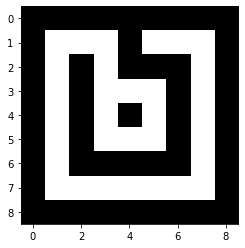

In [4]:
plot_predicted_path("data/g4-n4K/g4-n4K_tiny-v1_2022-09-07-12-46-21/model_final.pt", grid_n=4)